<a href="https://colab.research.google.com/github/dreamingv-oid/CS290/blob/main/gmm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


=== Penguins Dataset ===


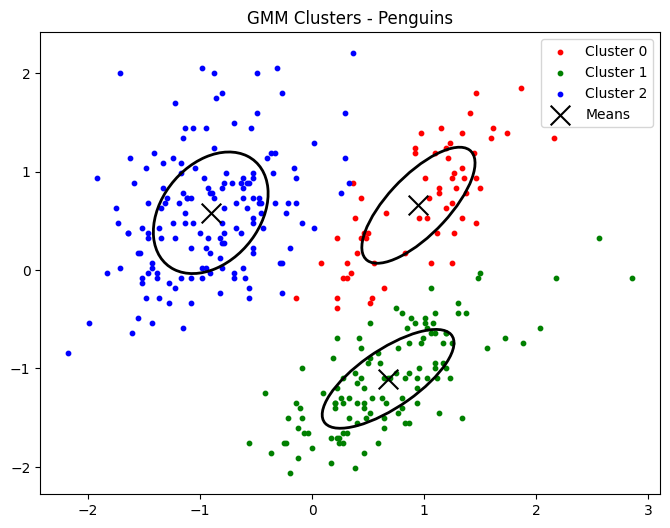

Penguins Accuracy: 0.96
Penguins Inertia: 202.38

=== Iris Dataset ===


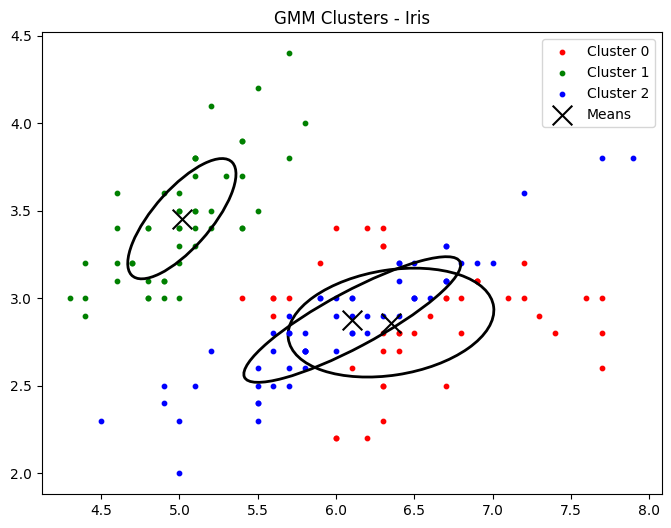

Iris Accuracy: 0.71
Iris Inertia: 65.14


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse
from sklearn.metrics import accuracy_score


# Load and preprocess the penguins dataset
def preprocess_penguins():
    penguins = pd.read_csv("https://github.com/mbrudd/csci290/raw/refs/heads/main/data/penguins.csv")
    penguins.columns = penguins.columns.str.strip()
    penguins.dropna(inplace=True)

    # Encode categorical features manually
    categorical_cols = ['island', 'sex', 'species']
    penguins_encoded = penguins.copy()
    label_encoders = {}

    for col in categorical_cols:
        unique_vals = penguins[col].unique()
        label_encoders[col] = {val: i for i, val in enumerate(unique_vals)}
        penguins_encoded[col] = penguins[col].map(label_encoders[col])

    # Standardize numerical features manually
    numerical_cols = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'year']
    penguins_encoded[numerical_cols] = (penguins_encoded[numerical_cols] - penguins_encoded[numerical_cols].mean()) / penguins_encoded[numerical_cols].std()

    X = penguins_encoded[numerical_cols[:2]].values  # Use first 2 numerical features for 2D visualization
    y = penguins_encoded['species'].values
    return X, y


# Load and preprocess the iris dataset
def preprocess_iris():
    from sklearn.datasets import load_iris
    iris = load_iris()
    X = iris.data[:, :2]  # Use first 2 features for 2D visualization
    y = iris.target
    return X, y


# Gaussian Mixture Model implementation

class GMM:
    from scipy.stats import mode
    def __init__(self, n_components, max_iter=100, tol=1e-4):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol

    def initialize_parameters(self, X):
        n_samples, n_features = X.shape
        self.means = X[np.random.choice(n_samples, self.n_components, replace=False)]
        self.covariances = np.array([np.cov(X, rowvar=False) for _ in range(self.n_components)])
        self.weights = np.ones(self.n_components) / self.n_components

    def e_step(self, X):
        n_samples = X.shape[0]
        self.responsibilities = np.zeros((n_samples, self.n_components))

        for k in range(self.n_components):
            self.responsibilities[:, k] = self.weights[k] * multivariate_normal.pdf(X, mean=self.means[k], cov=self.covariances[k])

        total_responsibility = np.sum(self.responsibilities, axis=1, keepdims=True)
        self.responsibilities /= total_responsibility

    def m_step(self, X):
        n_samples = X.shape[0]
        effective_n_k = np.sum(self.responsibilities, axis=0)

        self.weights = effective_n_k / n_samples
        self.means = np.array([np.sum(X * self.responsibilities[:, k].reshape(-1, 1), axis=0) / effective_n_k[k] for k in range(self.n_components)])
        self.covariances = np.array([
            np.dot((self.responsibilities[:, k] * (X - self.means[k]).T), (X - self.means[k])) / effective_n_k[k]
            for k in range(self.n_components)
        ])

    def fit(self, X):
        self.initialize_parameters(X)
        for _ in range(self.max_iter):
            self.e_step(X)
            self.m_step(X)
        return self

    def predict(self, X):
        self.e_step(X)
        return np.argmax(self.responsibilities, axis=1)



    def calculate_accuracy(self, X, true_labels):
      predicted_labels = self.predict(X)
      aligned_labels = np.zeros_like(predicted_labels)

      for i in range(self.n_components):
        mask = (predicted_labels == i)
        if np.any(mask):  # Check if there are any points in this cluster
            aligned_labels[mask] = np.atleast_1d(mode(true_labels[mask]).mode)[0]

      accuracy = np.mean(aligned_labels == true_labels)
      return accuracy



    def calculate_inertia(self, X):
        labels = self.predict(X)
        inertia = 0
        for i in range(self.n_components):
            cluster_points = X[labels == i]
            inertia += np.sum(np.linalg.norm(cluster_points - self.means[i], axis=1) ** 2)
        return inertia


def plot_gmm_clusters(X, gmm, dataset_name):
    labels = gmm.predict(X)
    colors = ['red', 'green', 'blue', 'purple', 'orange', 'cyan']
    plt.figure(figsize=(8, 6))

    for i in range(gmm.n_components):
        cluster_points = X[labels == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=10, color=colors[i % len(colors)], label=f'Cluster {i}')

        # Plot ellipse for covariance
        eigenvalues, eigenvectors = np.linalg.eigh(gmm.covariances[i])
        angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
        width, height = 2 * np.sqrt(eigenvalues)

        # Corrected Ellipse initialization
        ellipse = Ellipse(xy=gmm.means[i], width=width, height=height, angle=angle, edgecolor='black', facecolor='none', lw=2)

        plt.gca().add_patch(ellipse)

    plt.scatter(gmm.means[:, 0], gmm.means[:, 1], color='black', marker='x', s=200, label='Means')
    plt.title(f"GMM Clusters - {dataset_name}")
    plt.legend()
    plt.show()



# Main Execution
datasets = {
    "Penguins": preprocess_penguins(),
    "Iris": preprocess_iris()
}

for dataset_name, (X, y) in datasets.items():
    print(f"\n=== {dataset_name} Dataset ===")
    n_clusters = len(np.unique(y))
    gmm = GMM(n_components=n_clusters).fit(X)

    # Plot GMM clusters
    plot_gmm_clusters(X, gmm, dataset_name)

    # Calculate metrics
    accuracy = gmm.calculate_accuracy(X, y)
    inertia = gmm.calculate_inertia(X)

    print(f"{dataset_name} Accuracy: {accuracy:.2f}")
    print(f"{dataset_name} Inertia: {inertia:.2f}")
